## design leader sequence

In [91]:
import infrared as ir
import infrared.rna as rna
import RNA
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [92]:
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

In [93]:
design_09 =   'CCGCCCAG-G-GCCUA-GGCAGCACGC--GAAAUUAG---GCGACGGGA--GA--GGGUCGGA--UCCCGAC-UGGGCAG-CUGGGCAAUUUGUAA----UUUGUGAGACCC'
a =           "NNNNNNNNXXXNNNNXXGGCAGCRCRCXXNNNXXXXXXXXGYGACGGGXXXXXXXXGGUCXXXXXXCCCGACXXNNNNXXXNNNNNNNNNNNNXXXXXXXUUYGUGAXGACC"
structures = ['..(((((((..(((((((......(((((.........))))).(((((((............))))))).)))))))..))))))).........................',
		      '.....................(((..............................................................................))).......',
		      '.......................................................(((((...............................................)))))']
 
xrRNA_ss = [remove_positioned_gaps(design_09, ss) for ss in structures]
xrRNA_seq = design_09.replace('-','')
print(xrRNA_seq)
for i in xrRNA_ss: print(i)

CCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
..((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................
..................(((.............................................................))).......
...........................................(((((.......................................)))))


In [94]:
extended_iupac_nucleotides = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'U': 'U',
    'R': 'AG',
    'N': 'ACGU',
    'X': 'ACGU-',
    '-': '-',
    '.': '-'
}


def iupacvalues(symbol):
    return [ rna.nucleotide_to_value(x) for x in extended_iupac_nucleotides[symbol] ]

def sample_to_seq(sample):
    return rna.values_to_seq(sample.values())

def calculate_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq)

In [95]:
## GCUAA stays unpaired
target_leader =  ".........((((((....))))))...."
iupac_sequence = 'GCUAANNNXNNNNNXNNNXXNNNNNNNXX'


In [96]:
len(iupac_sequence)

29

In [97]:
n = len(target_leader)
model = ir.Model()
model.add_variables(n, 5)

for i, x in enumerate(iupac_sequence):
    model.add_constraints(ir.ValueIn(i, iupacvalues(x)))

model.add_constraints(rna.BPComp(i,j) for (i,j) in rna.parse(target_leader))
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')

sampler = ir.Sampler(model)
# samples = [sample_to_seq(sampler.sample()) for _ in range(10000)]
sampler.set_target( 0.5 * n, 0.1 * n, 'gc' )
samples = [sample_to_seq(sampler.targeted_sample()) for _ in tqdm(range(500000))]

100%|██████████| 500000/500000 [00:23<00:00, 21435.46it/s]


In [98]:
def target_frequency(sequence, ss):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(ss)

def acceptable_seq(seq, ss):
    if not ss.startswith('........'):
        return False
    return True

In [99]:
ok_leader= []
for seq in tqdm(samples):
    seq_ = seq.replace('-','')
    fc  = RNA.fold_compound(seq_)
    (ss, mfe) = fc.mfe()
    if acceptable_seq(seq_, ss):
        ok_leader.append(seq)

100%|██████████| 500000/500000 [01:01<00:00, 8098.74it/s]


In [100]:
len(ok_leader)

203732

In [101]:
def test_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss):
    target_ss = remove_positioned_gaps(leader_seq, target_leader)
    target_ss = target_ss + xrRNA_ss


    seq = leader_seq.replace('-','') + xrRNA_seq

    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    strikes = 0
    for s in fc.subopt(500):
        if s.structure[len(leader_seq):] != xrRNA_ss or not s.structure.startswith('.....'):
            return False
    return True

In [102]:
def print_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss, sample_size=1000):
    ss_leader = remove_positioned_gaps(leader_seq, target_leader)
    target_ss = ss_leader + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq
    
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    suboptimal_ss = []
    for s in fc.subopt(sample_size):
        if s.structure not in suboptimal_ss:
            print(seq)
            print(f"{s.structure}\t{s.energy:6.2f}")
            print(f'{"-" * len(ss_leader) + "+" * len(xrRNA_seq)}\n')
            suboptimal_ss.append(s.structure)
    return True

In [103]:
def test_interaction(leader_seq, xrRNA_seq, xrRNA_ss,threshold = 0.01):
    leader_seq = leader_seq.replace('-','')

    seq = leader_seq + xrRNA_seq
    fold_compound = RNA.fold_compound(seq)
    fold_compound.pf()
    base_pair_probs = np.array(fold_compound.bpp())
    for i in range(len(leader_seq)):
        for j in range(len(leader_seq), len(seq)):
            if base_pair_probs[i][j] > threshold:  # Adjust threshold as needed
                return False
    return True

In [104]:
good_candidates = []

for seq in tqdm(ok_leader):
    if test_interaction(seq, xrRNA_seq, xrRNA_ss[0], 0.05):
        good_candidates.append(seq)



100%|██████████| 203732/203732 [44:57<00:00, 75.52it/s] 


In [107]:
len(good_candidates)

1543

In [ ]:
best_seq = None
best_freq = 0
for seq in tqdm(ok_leader):
    target_ss = remove_positioned_gaps(seq, target_leader)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))
print(best_seq)

  0%|          | 14/40653 [00:00<10:57, 61.76it/s]

0.04
0.15
0.19


  0%|          | 58/40653 [00:00<08:35, 78.70it/s]

0.45


  3%|▎         | 1048/40653 [00:12<08:02, 82.00it/s]

0.48


 29%|██▉       | 11936/40653 [02:28<05:55, 80.82it/s]

0.5


 32%|███▏      | 13133/40653 [02:42<05:39, 81.15it/s]

0.51


 46%|████▌     | 18708/40653 [03:50<04:32, 80.67it/s]

0.51


100%|██████████| 40653/40653 [08:23<00:00, 80.81it/s]

GCUAAACCCCAUGGCAAAGGCCGUGAUU-


In [106]:
best_seq = None
best_freq = 0
for seq in tqdm(good_candidates):
    target_ss = remove_positioned_gaps(seq, target_leader)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))

print(best_seq)

  1%|          | 15/1543 [00:00<00:20, 73.47it/s]

0.43
0.47


  2%|▏         | 31/1543 [00:00<00:20, 74.06it/s]

0.49
0.51


 94%|█████████▍| 1450/1543 [00:17<00:01, 82.74it/s]

0.52


100%|██████████| 1543/1543 [00:18<00:00, 83.37it/s]

GCUAAACC-GUUCUGGACCCAGAGCUCC-


In [111]:
good_candidates_stored = ['GCUAAAAC-CAUAGCCGUAGCUAUGAU-C', 'GCUAAACUAGGAGGGGAAACCCUCCAUCC','GCUAAAGA-GCUUGCGUAAAGCAAGCAA--', 'GCUAAACCCCAUGGCAAAGGCCGUGAUU-', 'GCUAAACC-GUUCUGGACCCAGAGCUCC-']

In [ ]:
not_working = 'GCUAAAGAGCUUGCGUAAAGCAAGCAA'

In [112]:
best_seq = None
best_freq = 0
for seq in tqdm(good_candidates_stored):
    target_ss = remove_positioned_gaps(seq, target_leader)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))

print(best_seq)

100%|██████████| 5/5 [00:00<00:00, 47.44it/s]

0.51
0.52
GCUAAACC-GUUCUGGACCCAGAGCUCC-


In [ ]:
# og GCUAAAGAGCUUGCGUAAAGCAAGCAA
# L1 GCUAAAACCAUAGCCGUAGCUAUGAUC
# L2 GCUAAACCGUUCUGGACCCAGAGCUCC

In [114]:
best_seq = 'GCUAAACC-GUUCUGGACCCAGAGCUCC-'

In [115]:
print_suboptimal_ss(best_seq, xrRNA_seq, xrRNA_ss[0], 400)


GCUAAACCGUUCUGGACCCAGAGCUCCCCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................	-39.50
---------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

GCUAAACCGUUCUGGACCCAGAGCUCCCCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((....)))))).....((((((.((((((......(((........))).(((((..(...)...))))).))))))..)))))).....................	-38.30
---------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

GCUAAACCGUUCUGGACCCAGAGCUCCCCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((....)))))).....((((((.((((((......(((........))).(((((((...))...))))).))))))..)))))).....................	-37.60
-----------------

True

GCUAAACCGUUCUGGACCCAGAGCUCCCCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... (-39.50)
........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... [-39.90]
........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... {-39.50 d=1.90}
........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... {-39.50 MEA=115.76}
 frequency of mfe structure in ensemble 0.520725; ensemble diversity 3.70  


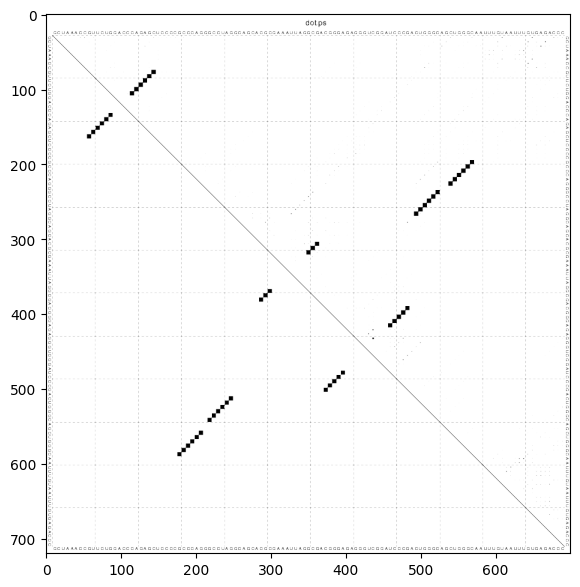

In [116]:
seq = best_seq.replace('-', '') + xrRNA_seq
!echo $seq > test.seq
!RNAfold -p --MEA < test.seq
!convert dot.ps dot.png

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("dot.png")
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)

In [119]:
print('........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................')
print('.' * len(best_seq.replace('-', '')) + xrRNA_ss[1])
print('.' * len(best_seq.replace('-', '')) + xrRNA_ss[2])

........((((((....)))))).....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................
.............................................(((.............................................................))).......
......................................................................(((((.......................................)))))


In [118]:
from varnaapi import Structure
import varnaapi
seq =  'GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC'
ss =  r'........((((((.....))))))....((((((.((((((...{{{(((........))).(((((..[[[[[...))))).))))))..))))))...........}}}..]]]]]'
ss =  r'........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................'

v = varnaapi.Structure(sequence=seq, structure=ss)
# .update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)


v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)
style_leader = varnaapi.param.BasesStyle(fill="blue")
style_xrRNA = varnaapi.param.BasesStyle(fill="red")

v.add_bases_style(style_leader, list(range(1,28)))
v.add_bases_style(style_xrRNA, list(range(28,len(ss)+1)))

v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)

v.show()
#v.savefig('/scr/aldea/kgutenbrunner/github/MA/xrRNA_design/MBFV_design/leader_design/structure.png')


Output file: /var/folders/54/ry4wc1s953jdm1j76gdcpwpc0000gn/T/tmp4e9bkp_l.svg



JupyterSvgImage(svg='<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" \n"http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n\n<svg width="600px" height="387px" version="1.1" viewBox="0 0 700 500" \nxmlns="http://www.w3.org/2000/svg">\n<line x1="15.0" y1="422.5096036616385" x2="22.5" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="32.5" y1="422.5096036616385" x2="40.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="50.0" y1="422.5096036616385" x2="57.5" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="67.5" y1="422.5096036616385" x2="75.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="85.0" y1="422.5096036616385" x2="92.5" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="102.5" y1="422.5096036616385" x2="110.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="120.0" y1="422.5096036616385" x2="127.5" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="137.5" y1="422.5096036616385" x2="145.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.0" y1="417.5096036616385" x2="150.0" y2="407.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.0" y1="397.5096036616385" x2="150.0" y2="387.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.0" y1="377.50960366163855" x2="150.0" y2="367.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.0" y1="357.50960366163855" x2="150.0" y2="347.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="150.0" y1="337.50960366163855" x2="150.0" y2="327.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="148.10052547530273" y1="317.88445539049894" x2="145.25130491987935" y2="310.9467116331235" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="145.27360479081668" y1="301.7056362425112" x2="148.15627525558693" y2="294.78172425520324" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="154.69860079960264" y1="288.2551671126246" x2="161.6294488516189" y2="285.389213258092" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="170.8705511483811" y1="285.389213258092" x2="177.80139920039738" y2="288.2551671126246" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="184.34372474441307" y1="294.78172425520324" x2="187.22639520918335" y2="301.7056362425112" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="187.24869508012065" y1="310.9467116331235" x2="184.39947452469727" y2="317.88445539049894" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="182.5" y1="327.50960366163855" x2="182.5" y2="337.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="182.5" y1="347.50960366163855" x2="182.5" y2="357.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="182.5" y1="367.50960366163855" x2="182.5" y2="377.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="182.5" y1="387.50960366163855" x2="182.5" y2="397.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="182.5" y1="407.5096036616385" x2="182.5" y2="417.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="187.5" y1="422.5096036616385" x2="195.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="205.0" y1="422.5096036616385" x2="212.5" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="222.5" y1="422.5096036616385" x2="230.0" y2="422.5096036616385" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="240.0" y1="422.50960366163855" x2="247.5" y2="422.50960366163855" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="257.5" y1="422.50960366163855" x2="265.0" y2="422.5096